<a href="https://colab.research.google.com/github/the-faisalahmed/Optimization/blob/main/N_Queens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

!pip install pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from IPython import display
from time import sleep

!pip install svgpath2mpl
from svgpath2mpl import parse_path

# **N-Queens Problem**
Given N queens, place all queens on an N×N chessboard in such a way that no two queens threaten each other.

In [358]:


path = """
M28.553 4.694c-1.104 0-1.998 0.895-1.998 1.999 0 0.669 0.329 1.26 0.833 1.623l-3.16
4.962c0.673 0.357 1.132 1.064 1.132 1.879 0 1.173-0.951 2.125-2.124 2.125s-2.124-0.951-2.124-2.125c0-1.067
0.786-1.95 1.811-2.102l-2.168-5.088c0.954-0.223 1.665-1.078 1.665-2.1 0-1.191-0.965-2.157-2.156-2.157s-2.156
0.966-2.156 2.157c0 0.923 0.58 1.711 1.396 2.019l-2.777 4.737c0.912 0.282 1.574 1.132 1.574 2.137 0 1.235-1.001
2.237-2.236 2.237s-2.236-1.001-2.236-2.237c0-0.946 0.587-1.754 1.416-2.081l-2.755-4.785c0.826-0.302 1.416-1.095
1.416-2.027 0-1.191-0.965-2.157-2.156-2.157s-2.156 0.966-2.156 2.157c0 1.003 0.685 1.847 1.613 2.088l-2.204 5.112c0.99
0.181 1.74 1.047 1.74 2.090 0 1.173-0.951 2.125-2.124 2.125s-2.124-0.951-2.124-2.125c0-0.834 0.481-1.556
1.18-1.904l-3.17-4.943c0.5-0.363 0.825-0.952 0.825-1.617 0-1.104-0.895-1.999-1.998-1.999s-1.998
0.895-1.998 1.999 0.895 1.999 1.998 1.999c0.046 0 0.092-0.002 0.138-0.005l2.826 15.312c-1.712 0.045-1.717
2.507 0.048 2.507h0.415l0.004 0.020h18.364l0.004-0.020h0.475c1.718 0 1.749-2.508 0-2.508h-0.013l2.826-15.311c0.045
0.003 0.091 0.005 0.137 0.005 1.104 0 1.998-0.895 1.998-1.999s-0.895-1.999-1.998-1.999z
"""

queen = parse_path(path)
queen.vertices = queen.vertices*-1

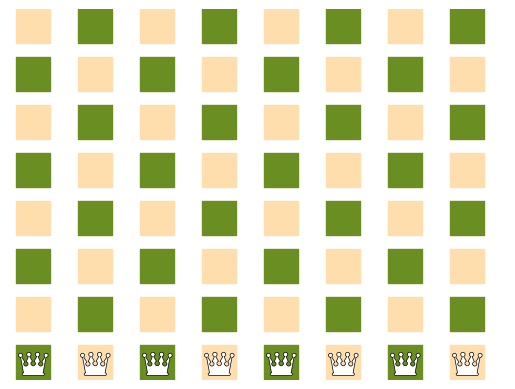

In [394]:
N = 8

size = 610

for i,j in list(itertools.product(list(range(1,N+1)),list(range(1,N+1)))):
  if (j % 2 == 0 and i % 2 == 0) or (j % 2 != 0 and i % 2 != 0):
    plt.scatter(i,j,marker = 's',s=size, c=['#6B8E23'])
  else:
    plt.scatter(i,j,marker = 's',s=size, c=['#FFDEAD'])

for i,j in list(itertools.product(list(range(1,N+1)),[1])):
      plt.scatter(i+.26,j+.3,marker = queen,s=2000, c='w', \
                  edgecolors = 'k', linewidths = .5)


plt.axis('off');

plt.savefig('/content/n_queens_folder/n_queens_images%d_%s'%(0,'pic.jpg'))


[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]

In [248]:
model = ConcreteModel()
model.I = RangeSet(1,N)
model.X = Var(model.I, model.I, domain = Binary)

# All queens used exactly once
model.cons1 = Constraint(expr = sum(model.X[i,j] for i,j in list(itertools.product((model.I),(model.I)))) == N)

# No queens should challenge one another vertically
def cons_rule2(model,i):
  return sum(model.X[(i,j)] for j in model.I) <= 1
model.cons2 = Constraint(model.I, rule = cons_rule2)

# No queens should challenge one another horizontally
def cons_rule3(model,j):
  return sum(model.X[(i,j)] for i in model.I) <= 1
model.cons3 = Constraint(model.I, rule = cons_rule3)

# No queens should challenge one another diagonally right
def cons_rule4(model,i,j):
  return sum(model.X[(i+k,j+k)] for k in range(-N+1,N) \
             if ((i+k),(j+k)) in list(itertools.product((model.I),(model.I)))) <= 1
model.cons4 = Constraint(model.I, model.I, rule = cons_rule4)

# No queens should challenge one another diagonally left
def cons_rule5(model,i,j):
  return sum(model.X[(i-k,j+k)] for k in range(-N+1,N) \
             if ((i-k),(j+k)) in list(itertools.product((model.I),(model.I)))) <= 1
model.cons5 = Constraint(model.I, model.I, rule = cons_rule5)

model.obj = Objective(expr=1)

In [249]:
# Solve model
opt = SolverFactory('cbc')
result = opt.solve(model)

if (result.solver.status == SolverStatus.ok) and \
    (result.solver.termination_condition == TerminationCondition.optimal):
    # Do something when the solution in optimal and feasible
    print('Solution is Optimal')
elif (result.solver.termination_condition == TerminationCondition.infeasible):
    # Do something when model in infeasible
    print('Solution is Infeasible')
else:
        # Something else is wrong
    print("Solver Status:",  result.solver.status)

# Solve time
print('Solve Time: ', result.solver.wallclock_time)

Solution is Optimal
Solve Time:  0.02


In [250]:
x_vals = pd.Series(model.X.extract_values(), name='vals')
g = x_vals[x_vals>0]
g

# List of spaces that each queen challenges
challenging = {}
for i,j in g.keys():
    # Columns challenged
    challenging[i,j] = [[(i,k) for k in range(1,N+1) if (i,k) not in g.keys()]]
    # Rows challenged
    challenging[i,j].append([(k,j) for k in range(1,N+1) if (k,j) not in g.keys()])
    # Diagonals challenged, top right bottom left
    challenging[i,j].append([(i+k,j+k) for k in range(-N+1,N) \
                             if (i+k,j+k) not in g.keys() and (i+k,j+k) in list(itertools.product((model.I),(model.I)))])
    # Diagonals challenged, bottom right top left
    challenging[i,j].append([(i-k,j+k) for k in range(-N+1,N) \
                             if (i-k,j+k) not in g.keys() and (i-k,j+k) in list(itertools.product((model.I),(model.I)))])


In [403]:
#!mkdir n_queens_folder

size = 610
marker = 10

count = 0

for (i,j) in challenging.keys():
  plt.axis('off')

  #Original board
  for (a,b) in list(itertools.product((model.I),(model.I))):
    if (a % 2 == 0 and b % 2 == 0) or (a % 2 != 0 and b % 2 != 0):
      plt.scatter(a,b,marker = 's',s=size, c=['#6B8E23'])
    else:
      plt.scatter(a,b,marker = 's',s=size, c=['#FFDEAD'])

  #Adding queens
  for (a,b) in list(itertools.product((model.I),(model.I))):
    if (a,b) in g.keys():
      plt.scatter(a+.26,b+.3,marker = queen,s=2000, c='w', \
                edgecolors = 'k', linewidths = .5)

  #Plotting spaces that each queen challenges
  for k in range(len(challenging[i,j])):
    for x in range(len(challenging[i,j][k])):
      count+=1
      a,b = challenging[i,j][k][x]
      c,d = challenging[i,j][k][x]
      plt.plot((i,a), (j,b), '-bo', markersize = marker, c = 'r', lw=2, markevery=[0])
      plt.plot((i,c), (j,d), '-bo', markersize = marker, c = 'r', lw=2, markevery=[0])
      display.display(plt.gcf())
      #plt.savefig('/content/n_queens_folder/n_queens_images%d_%s'%(count,'pic.jpg'))
      display.clear_output(wait=True)
      sleep(0.005)
  plt.clf()

plt.show();

#!zip -r /content/n_queens_images.zip /content/n_queens_folder

<Figure size 640x480 with 0 Axes>

updating: content/n_queens_folder/ (stored 0%)
updating: content/n_queens_folder/n_queens_images6_pic.jpg (deflated 28%)
updating: content/n_queens_folder/n_queens_images8_pic.jpg (deflated 26%)
updating: content/n_queens_folder/n_queens_images1_pic.jpg (deflated 29%)
updating: content/n_queens_folder/n_queens_images3_pic.jpg (deflated 29%)
updating: content/n_queens_folder/n_queens_images2_pic.jpg (deflated 29%)
updating: content/n_queens_folder/n_queens_images7_pic.jpg (deflated 28%)
updating: content/n_queens_folder/n_queens_images5_pic.jpg (deflated 28%)
updating: content/n_queens_folder/n_queens_images4_pic.jpg (deflated 27%)
updating: content/n_queens_folder/n_queens_images14_pic.jpg (deflated 27%)
updating: content/n_queens_folder/n_queens_images11_pic.jpg (deflated 27%)
updating: content/n_queens_folder/n_queens_images18_pic.jpg (deflated 25%)
updating: content/n_queens_folder/n_queens_images24_pic.jpg (deflated 30%)
updating: content/n_queens_folder/n_queens_images23_pic.jpg (